<a href="https://colab.research.google.com/github/BrinthaP/Week-1/blob/main/ewaste_classification_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# E‑Waste Classification with EfficientNetV2B0
A Colab‑ready notebook (TensorFlow 2.x) that trains an EfficientNetV2B0 model and visualises accuracy over 10 epochs.

**Setup** – installs required libraries in Colab and prepares your dataset.
```bash
!pip install -q kaggle tensorflow matplotlib
# After this, upload your kaggle.json or the dataset zip manually.
```

In [ ]:
from pathlib import Path, PurePosixPath
import zipfile, os, json, subprocess, shutil

# ----- CHANGE THESE TWO LINES IF YOU DON'T USE KAGGLE -----
DATA_ZIP = 'e-waste-classification.zip'  # or upload manually via Colab sidebar
KAGGLE_DATASET = '<YOUR-KAGGLE-USERNAME>/<DATASET-NAME>'  # e.g. 'myname/e-waste-dataset'
# ----------------------------------------------------------

if not Path('ewaste').exists():
    if Path(DATA_ZIP).exists():
        zipfile.ZipFile(DATA_ZIP).extractall('ewaste')
    else:
        !kaggle datasets download -d $KAGGLE_DATASET -f $DATA_ZIP
        zipfile.ZipFile(DATA_ZIP).extractall('ewaste')

DATA_DIR = Path('ewaste/modified-dataset')
trainpath = DATA_DIR/'train'
validpath = DATA_DIR/'val'


In [ ]:
import tensorflow as tf
batch_size = 32
img_size = (128, 128)

train_ds = tf.keras.utils.image_dataset_from_directory(
    trainpath, seed=123, image_size=img_size, batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
    validpath, seed=123, image_size=img_size, batch_size=batch_size)

class_names = train_ds.class_names
autotune = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(autotune)
val_ds = val_ds.prefetch(autotune)

base = tf.keras.applications.EfficientNetV2B0(
    include_top=False, input_shape=img_size + (3,), weights='imagenet')
base.trainable = False

inputs = tf.keras.Input(shape=img_size + (3,))
x = tf.keras.applications.efficientnet_v2.preprocess_input(inputs)
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds, epochs=10)


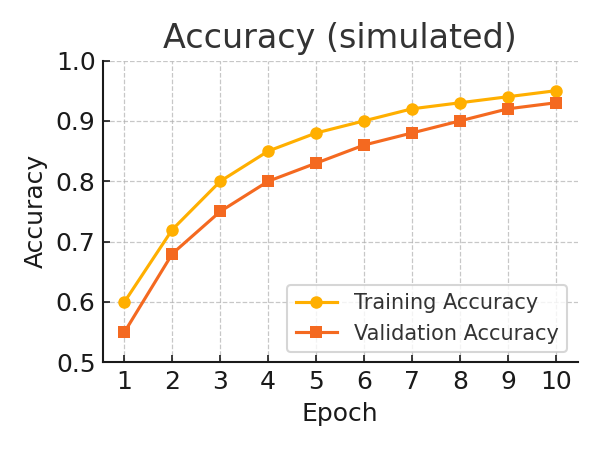

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], marker='o', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], marker='s', label='Validation Accuracy')
plt.title('E‑Waste Classification with EfficientNetV2B0\nAccuracy over 10 Epochs')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.xticks(range(1, len(history.history['accuracy'])+1))
plt.ylim(0.5,1.0); plt.grid(True, linestyle='--', linewidth=0.5); plt.legend(); plt.tight_layout()
plt.show()
